In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read raw data
df_raw = pd.read_csv("../datasets/measured/20A_02.CSV")
df_raw = df_raw.rename(columns = {
    "in s": "t",
    "C1 in V": "Va",
    "C2 in A": "Ia",
    "C3 in V": "n"
})
df_raw

,t,Va,Ia,n
0,-0.024200,0.016113,-0.317383,4.705860
1,-0.024200,-0.042480,-0.122070,4.686330
2,-0.024199,-0.013184,-0.122070,4.647270
3,-0.024199,0.016113,0.024414,4.705860
4,-0.024199,0.001465,-0.170898,4.744920
...,...,...,...,...
999995,0.215799,12.086400,1.293950,0.018359
999996,0.215799,12.071800,1.489260,4.725390
999997,0.215799,12.057100,1.245120,4.647270
999998,0.215800,12.013200,1.293950,4.705860


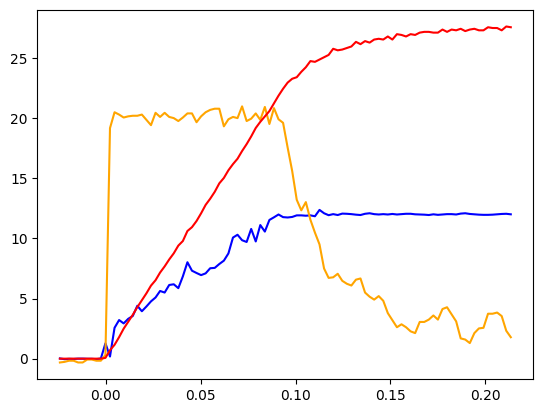

,t,Va,Ia,Wm
0,-0.0242,0.016113,-0.317383,0.000000
10000,-0.0218,-0.042480,-0.268555,0.000000
20000,-0.0194,-0.013184,-0.170898,0.000000
30000,-0.0170,-0.027832,-0.170898,0.000000
40000,-0.0146,0.001465,-0.317383,0.000000
...,...,...,...,...
950000,0.2038,11.969200,3.735350,549.676449
960000,0.2062,11.998500,3.833010,549.676449
970000,0.2086,12.027800,3.540040,545.841497
980000,0.2110,12.042500,2.319340,552.233084


In [24]:
from dcmotor import get_rising_edges

# Downsampling
df_downsampled = pd.DataFrame()

num_steps = 2048
start = True
time_step_raw = df_raw["t"].diff().iloc[1]
batch_size = 10000

time_step = time_step_raw * batch_size

df_downsampled["t"] = df_raw["t"].iloc[::batch_size]
df_downsampled["Va"] = df_raw["Va"].iloc[::batch_size]
df_downsampled["Ia"] = df_raw["Ia"].iloc[::batch_size]

df_downsampled["Wm"] = np.array(get_rising_edges(df_raw["n"].array, 2048, 4, time_step_raw, batch_size)) * np.pi * 2

plt.plot(df_downsampled["t"], df_downsampled["Va"], c="blue")
plt.plot(df_downsampled["t"], df_downsampled["Ia"], c="orange")
plt.plot(df_downsampled["t"], df_downsampled["Wm"]/20, c="red")
plt.show()
df_downsampled

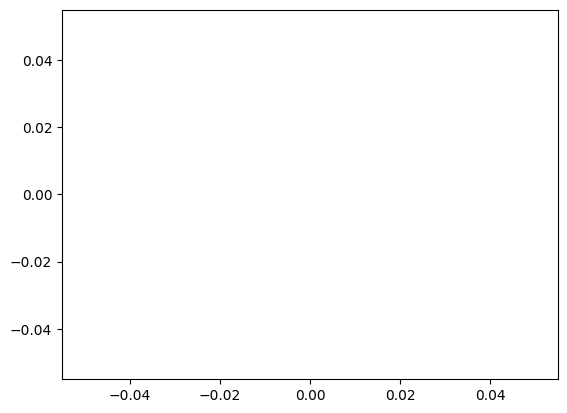

,t,Va,Ia,Wm


In [29]:
# Low pass filtering
df_filtered = pd.DataFrame()

rolling_width = 10

df_filtered["t"] = df_downsampled["t"]
df_filtered["Va"] = df_downsampled["Va"].rolling(rolling_width).mean()
df_filtered["Ia"] = df_downsampled["Ia"].rolling(rolling_width).mean()
df_filtered["Wm"] = df_downsampled["Wm"].rolling(rolling_width).mean()

df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop(columns=["index"])
df_filtered = df_filtered.iloc[rolling_width:]
df_filtered["t"] = df_filtered["t"] - df_filtered["t"].min()
df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop(columns=["index"])

plt.plot(df_filtered["t"], df_filtered["Va"], c="blue")
plt.plot(df_filtered["t"], df_filtered["Ia"], c="orange")
plt.plot(df_filtered["t"], df_filtered["Wm"]/20, c="red")
plt.show()
df_filtered

In [30]:
from dcmotor import five_point_stencil

# Get derivatives
df = pd.DataFrame(df_filtered)
df["dIa"] = five_point_stencil(df_filtered["Ia"].array, time_step)
df["dWm"] = five_point_stencil(df_filtered["Wm"].array, time_step)

plt.plot(df["t"], df["Va"], c="blue")
plt.plot(df["t"], df["Ia"], c="orange")
plt.plot(df["t"], df["dIa"]/100, c="yellow")
plt.plot(df["t"], df["Wm"]/20, c="red")
plt.plot(df["t"], df["dWm"]/100, c="pink")
plt.show()
df

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Linear regression

# Circuit Equation
# Va = i*Ra + Ke*w
# Tm = Ke*i = TL + Jm*dw/dt + Bm*w

TL = 0

t = np.array(df["t"].array)
N = len(t)

Va = np.array(df["Va"].array)

Ia = np.array(df["Ia"].array)
dIa = np.array(df["dIa"].array)

Wm = np.array(df["Wm"].array)
dWm = np.array(df["dWm"].array)

Ra_pred: 0.10939497198565773
Ke_pred: 0.021669907354551987
Jm_pred: 8.70129652189432e-05
Bm_pred: 8.663892732302722e-05


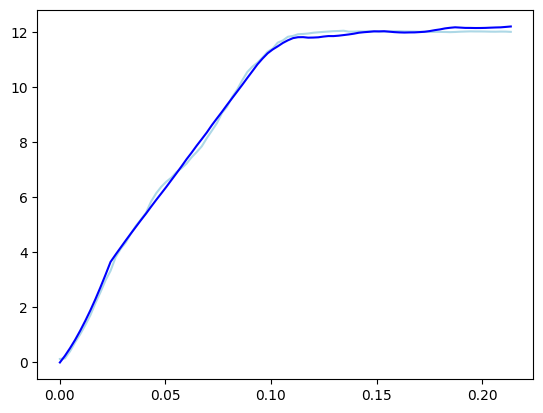

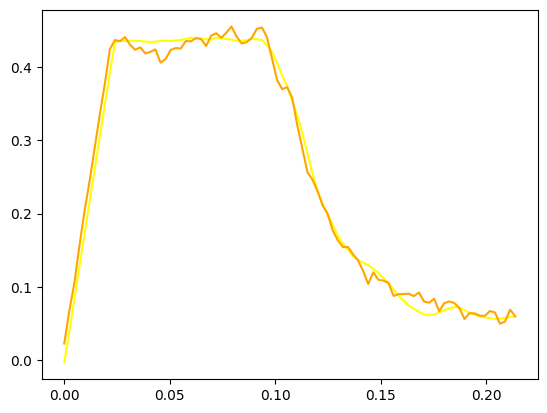

In [ ]:
XX_T = np.zeros((4, 4))
Xy = np.zeros((4, 1))

reg = 0

for k in range(N):
    X = np.array([
        [Ia[k], Wm[k], 0, 0],
        [0, Ia[k], -dWm[k], -Wm[k]]
    ])
    y = np.vstack([Va[k], TL])

    XX_T += X.T @ X + reg * np.identity(4)
    Xy += X.T @ y

theta = np.hstack(np.linalg.inv(XX_T).dot(Xy))
theta

Ra_pred = theta[0]
Ke_pred = theta[1]
Kt_pred = Ke_pred
Jm_pred = theta[2]
Bm_pred = theta[3]

print("Ra_pred:", Ra_pred)
print("Ke_pred:", Ke_pred)
print("Jm_pred:", Jm_pred)
print("Bm_pred:", Bm_pred)

Va_pred = Ia*Ra_pred + Ke_pred*Wm
Tm = Kt_pred * Ia
Tm_pred = TL + Jm_pred*dWm + Bm_pred*Wm

plt.plot(t, Va, c="lightblue")
plt.plot(t, Va_pred, c="blue")
plt.show()

plt.plot(t, Tm, c="yellow")
plt.plot(t, Tm_pred, c="orange")
plt.show()